In [2]:
import matplotlib 
import matplotlib.pyplot as plt
import pandas as pd
import anndata as ad
import dynamo as dyn
import scanpy as sc
dyn.get_all_dependencies_version()

/lustre/grp/tfclab/chenzg/miniconda3/envs/py3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


package,umap-learn,typing-extensions,tqdm,statsmodels,setuptools,session-info,seaborn,scipy,scikit-learn,pynndescent,pre-commit,pandas,openpyxl,numpy,numdifftools,numba,networkx,matplotlib,loompy,get-version,dynamo-release,colorcet,anndata
version,0.5.5,4.10.0,4.66.2,0.14.1,69.2.0,1.0.0,0.13.2,1.12.0,1.4.1.post1,0.5.11,3.7.0,1.5.3,3.1.2,1.23.5,0.9.41,0.59.0,3.2.1,3.8.3,3.0.6,3.5.5,1.3.2,3.1.0,0.10.6


# Gene-based

In [2]:
adata_total = ad.read_h5ad("results/gene_based.h5ad")
mtx1 = pd.read_csv("results/blastocyst_counts.genes.gene_name.total.tsv", sep="\t", index_col=0).T
mtx2 = pd.read_csv("results/blastocyst_counts.genes.gene_name.nascent.tsv", sep="\t", index_col=0).T
meta = pd.read_csv("results/blastocyst_counts.genes.gene_name.meta.tsv", sep="\t", index_col=1)

In [13]:
adata = ad.AnnData(mtx1.copy())
adata.layers["total"] = mtx1.copy()
adata.layers["new"] = mtx2.copy()
adata.obs = meta.copy()
adata = adata[adata.obs.index.isin(adata_total.obs.index)]
adata = adata[(adata.obs["s4U"] == 400) & (adata.obs["Time"] == 3) & (adata.obs["ActD"].isna()) & (adata.obs["TC.Ratio"] >= 0)]
adata.obs["CellType"] = adata_total.obs.loc[adata.obs.index]["CellType"].copy()
adata.obs["group"] = adata.obs["CellType"]
adata.obs["time"] = 3
print("Cells:", len(adata))
dyn.pp.recipe_monocle(adata, tkey="time")
dyn.tl.dynamics(adata, model='stochastic', cores=3, NTR_vel=True)
dyn.tl.reduceDimension(adata)
dyn.tl.leiden(adata)
dyn.tl.hdbscan(adata)
dyn.tl.louvain(adata)
if True: # correct stream direction
    lineage_dict = {
        "TE-1": ["muralTE", "polarTE"], 
        "ICM-1": ["EPI", "PE"],
        # "ICM-2": ["EPI"]
    }
    dyn.tl.gene_wise_confidence(adata, group='CellType', lineage_dict=lineage_dict, ekey="M_t", vkey="velocity_T")
    adata = adata[:,(adata.var["avg_prog_confidence"] > 0) & (adata.var["avg_mature_confidence"] > 0.5)]
dyn.tl.cell_velocities(adata, calc_rnd_vel=True)
dyn.vf.VectorField(adata, basis='umap')

/lustre/grp/tfclab/chenzg/tmp/ipykernel_222914/1953573129.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["CellType"] = adata_total.obs.loc[adata.obs.index]["CellType"].copy()


Cells: 2136
|-----? dynamo.preprocessing.deprecated is deprecated.
|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...


/lustre/grp/tfclab/chenzg/tmp/ipykernel_222914/1953573129.py:11: DeprecationWarning: recipe_monocle is deprecated and will be removed in a future release. Please update your code to use the new replacement function.
  dyn.pp.recipe_monocle(adata, tkey="time")


|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----> detected experiment type: one-shot
|-----> filtering cells...
|-----> 2136 cells passed basic filters.
|-----> filtering gene...
|-----> 12918 genes passed basic filters.
|-----> calculating size factor...
|-----> selecting genes in layer: X, sort method: SVR...
|-----> size factor normalizing the data, followed by log1p transformation.
|-----> Set <adata.X> to normalized data
|-----> applying PCA ...
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> cell cycle scoring...
|-----> computing cell phase...
|-----> [Cell Phase Estimation] completed [411.1502s]
|-----> [Cell Cycle Scores Estimation] completed [0.1853s]
|-----> [recipe_monocle preprocess] completed [29.8569s]
|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False


/lustre/grp/tfclab/chenzg/miniconda3/envs/py3/lib/python3.10/site-packages/dynamo/preprocessing/utils.py:730: RuntimeWarning: invalid value encountered in divide
  var_ntr = adata.layers["new"].sum(0) / adata.layers["total"].sum(0)


|-----------> removing existing M layers:[]...
|-----------> making adata smooth...
|-----> calculating first/second moments...
|-----> [moments calculation] completed [20.1212s]
|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [13.6019s]
|-----> accessing adj_matrix_key=connectivities built from args for clustering...
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> Detecting communities on graph...
|-----------> Converting graph_sparse_matrix to igraph object
|-----> [Community clustering with leiden] completed [506.0169s]
|-----> [hdbscan density-based-clustering] completed [0.5121s]
|-----> accessing adj_matrix_key=connectivities built 

calculating gene velocity vectors confidence based on phase portrait location with priors of progenitor/mature cell types: 2000it [00:26, 76.73it/s]
/lustre/grp/tfclab/chenzg/miniconda3/envs/py3/lib/python3.10/site-packages/dynamo/tools/metric_velocity.py:436: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg = confidence.groupby("gene")["prog_confidence", "mature_confidence"].mean()
/lustre/grp/tfclab/chenzg/miniconda3/envs/py3/lib/python3.10/site-packages/dynamo/tools/utils.py:2307: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var[store_key] = (


|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [4.6590s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.4195s]
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [4.6470s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.3938s]
|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector fi

In [17]:
cmap = matplotlib.colormaps["tab20"]
palette = {
    "ICM-1": cmap(1), 
    "ICM-2": cmap(3),
    "EPI": cmap(5),
    "PE": cmap(7),
    "TE-1": cmap(9),
    "TE-2": cmap(11),
    "muralTE": cmap(13),
    "polarTE": cmap(15)
}

color = "CellType"
pointsize = 0.2
fig, axs = plt.subplots(1, 2, figsize=(7.5, 3))
dyn.pl.streamline_plot(adata, color=color, color_key=palette, pointsize=pointsize, ax=axs[0],
                       basis='umap', show_legend=False, save_show_or_return='return')
dyn.pl.streamline_plot(adata, color=color, color_key=palette, pointsize=pointsize, ax=axs[1],
                       basis='umap_rnd', show_legend='right', save_show_or_return='return')
for ax in axs:
    ax.set_title(None)
plt.tight_layout()
if False:
    plt.show()
else:
    plt.savefig("figures/dynamo_umap_gene_based.png", dpi=300)
plt.close()

|-----------> plotting with basis key=X_umap
|-----------> skip filtering CellType by stack threshold when stacking color because it is not a numeric type
|-----------> plotting with basis key=X_umap_rnd
|-----------> skip filtering CellType by stack threshold when stacking color because it is not a numeric type


# Transcript-based

In [18]:
adata_total = ad.read_h5ad("results/transcript_based.h5ad")
mtx1 = pd.read_csv("results/blastocyst_counts.transcripts.transcript_name.total.tsv", sep="\t", index_col=0).T
mtx2 = pd.read_csv("results/blastocyst_counts.transcripts.transcript_name.nascent.tsv", sep="\t", index_col=0).T
meta = pd.read_csv("results/blastocyst_counts.transcripts.transcript_name.meta.tsv", sep="\t", index_col=1)

In [30]:
adata = ad.AnnData(mtx1.copy())
adata.layers["total"] = mtx1.copy()
adata.layers["new"] = mtx2.copy()
adata.obs = meta.copy()
adata = adata[adata.obs.index.isin(adata_total.obs.index)]
adata = adata[(adata.obs["s4U"] == 400) & (adata.obs["Time"] == 3) & (adata.obs["ActD"].isna()) & (adata.obs["TC.Ratio"] >= 0)]
adata.obs["CellType"] = adata_total.obs.loc[adata.obs.index]["CellType"].copy()
adata.obs["group"] = adata.obs["CellType"]
adata.obs["time"] = 3
sc.pp.filter_cells(adata, min_genes=600)
print("Cells:", len(adata))
dyn.pp.recipe_monocle(adata, tkey="time")
dyn.tl.dynamics(adata, model='stochastic', cores=3, NTR_vel=True)
dyn.tl.reduceDimension(adata)
dyn.tl.leiden(adata)
dyn.tl.hdbscan(adata)
dyn.tl.louvain(adata)
if True: # correct stream direction
    lineage_dict = {
        "TE-1": ["muralTE", "polarTE"], 
        "ICM-1": ["EPI", "PE"],
    }
    dyn.tl.gene_wise_confidence(adata, group='CellType', lineage_dict=lineage_dict, ekey="M_t", vkey="velocity_T")
    adata = adata[:,(adata.var["avg_prog_confidence"] > 0) & (adata.var["avg_mature_confidence"] > 0.5)]
dyn.tl.cell_velocities(adata, calc_rnd_vel=True)
dyn.vf.VectorField(adata, basis='umap')

/lustre/grp/tfclab/chenzg/tmp/ipykernel_222914/1779850402.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["CellType"] = adata_total.obs.loc[adata.obs.index]["CellType"].copy()


Cells: 2126
|-----? dynamo.preprocessing.deprecated is deprecated.
|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...


/lustre/grp/tfclab/chenzg/tmp/ipykernel_222914/1779850402.py:12: DeprecationWarning: recipe_monocle is deprecated and will be removed in a future release. Please update your code to use the new replacement function.
  dyn.pp.recipe_monocle(adata, tkey="time")


|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----> detected experiment type: one-shot
|-----> filtering cells...
|-----> 2126 cells passed basic filters.
|-----> filtering gene...
|-----> 12605 genes passed basic filters.
|-----> calculating size factor...
|-----> selecting genes in layer: X, sort method: SVR...
|-----> size factor normalizing the data, followed by log1p transformation.
|-----> Set <adata.X> to normalized data
|-----> applying PCA ...
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> cell cycle scoring...
|-----> computing cell phase...
|-----? 
Dynamo is not able to perform cell cycle staging for you automatically. 
Since dyn.pl.phase_diagram in dynamo by default colors cells by its cell-cycle stage, 
you need to set color argument accordingly if confronting errors related to this.
|-----> [recipe_monocle preprocess] completed [

/lustre/grp/tfclab/chenzg/miniconda3/envs/py3/lib/python3.10/site-packages/dynamo/preprocessing/utils.py:730: RuntimeWarning: invalid value encountered in divide
  var_ntr = adata.layers["new"].sum(0) / adata.layers["total"].sum(0)


|-----> [moments calculation] completed [20.4722s]
|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [13.6704s]
|-----> accessing adj_matrix_key=connectivities built from args for clustering...
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> Detecting communities on graph...
|-----------> Converting graph_sparse_matrix to igraph object
|-----> [Community clustering with leiden] completed [300.3281s]
|-----> [hdbscan density-based-clustering] completed [0.5627s]
|-----> accessing adj_matrix_key=connectivities built from args for clustering...
|-----> Detecting communities on graph...
|-----------> Converting graph_sparse_matrix to igraph obj

calculating gene velocity vectors confidence based on phase portrait location with priors of progenitor/mature cell types: 2000it [00:24, 82.65it/s]
/lustre/grp/tfclab/chenzg/miniconda3/envs/py3/lib/python3.10/site-packages/dynamo/tools/metric_velocity.py:436: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg = confidence.groupby("gene")["prog_confidence", "mature_confidence"].mean()
/lustre/grp/tfclab/chenzg/miniconda3/envs/py3/lib/python3.10/site-packages/dynamo/tools/utils.py:2307: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var[store_key] = (


|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [7.0128s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.6081s]
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [6.2996s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.4984s]
|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector fi

In [33]:
cmap = matplotlib.colormaps["tab20"]
palette = {
    "ICM-1": cmap(1), 
    "ICM-2": cmap(3),
    "EPI": cmap(5),
    "PE": cmap(7),
    "TE-1": cmap(9),
    "TE-2": cmap(11),
    "muralTE": cmap(13),
    "polarTE": cmap(15)
}
color = "CellType"
pointsize = 0.2
fig, axs = plt.subplots(1, 2, figsize=(7.5, 3))
dyn.pl.streamline_plot(adata, color=color, color_key=palette, pointsize=pointsize, ax=axs[0],
                       basis='umap', show_legend=False, save_show_or_return='return')
dyn.pl.streamline_plot(adata, color=color, color_key=palette, pointsize=pointsize, ax=axs[1],
                       basis='umap_rnd', show_legend='right', save_show_or_return='return')
for ax in axs:
    ax.set_title(None)
plt.tight_layout()
if False:
    plt.show()
else:
    plt.savefig("figures/dynamo_umap_transcript_based.png", dpi=300)
plt.close()

|-----------> plotting with basis key=X_umap
|-----------> skip filtering CellType by stack threshold when stacking color because it is not a numeric type
|-----------> plotting with basis key=X_umap_rnd
|-----------> skip filtering CellType by stack threshold when stacking color because it is not a numeric type


# Gene-based (ICM-2, EPI, PE)

In [5]:
adata_total = ad.read_h5ad("results/gene_based.h5ad")
mtx1 = pd.read_csv("results/blastocyst_counts.genes.gene_name.total.tsv", sep="\t", index_col=0).T
mtx2 = pd.read_csv("results/blastocyst_counts.genes.gene_name.nascent.tsv", sep="\t", index_col=0).T
meta = pd.read_csv("results/blastocyst_counts.genes.gene_name.meta.tsv", sep="\t", index_col=1)

In [6]:
adata = ad.AnnData(mtx1.copy())
adata.layers["total"] = mtx1.copy()
adata.layers["new"] = mtx2.copy()
adata.obs = meta.copy()
adata = adata[adata.obs.index.isin(adata_total.obs.index)]
adata = adata[(adata.obs["s4U"] == 400) & (adata.obs["Time"] == 3) & (adata.obs["ActD"].isna()) & (adata.obs["TC.Ratio"] >= 0.002)]
adata.obs["CellType"] = adata_total.obs.loc[adata.obs.index]["CellType"].copy()
adata.obs["group"] = adata.obs["CellType"]
adata.obs["time"] = 3
adata = adata[adata.obs["CellType"].isin(["ICM-1", "ICM-2", "EPI", "PE"]), :]
print("Cells:", len(adata))

/lustre/grp/tfclab/chenzg/tmp/ipykernel_2036774/1294163762.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["CellType"] = adata_total.obs.loc[adata.obs.index]["CellType"].copy()


Cells: 1260


In [131]:
dyn.pp.recipe_monocle(adata, tkey="time")
dyn.tl.dynamics(adata, model='stochastic', cores=3, NTR_vel=True)
dyn.tl.reduceDimension(adata)
dyn.tl.leiden(adata)
dyn.tl.hdbscan(adata)
dyn.tl.louvain(adata)
if True: # correct stream direction
    lineage_dict = {
        "ICM-1": ["EPI", "PE"],
        # "ICM-2": ["EPI"]
    }
    dyn.tl.gene_wise_confidence(adata, group='CellType', lineage_dict=lineage_dict, ekey="M_t", vkey="velocity_T")
    adata = adata[:,(adata.var["avg_prog_confidence"] > 0.2) & (adata.var["avg_mature_confidence"] > 0.5)]
dyn.tl.cell_velocities(adata, calc_rnd_vel=True)
dyn.vf.VectorField(adata, basis='umap')

|-----? dynamo.preprocessing.deprecated is deprecated.
|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...


/lustre/grp/tfclab/chenzg/tmp/ipykernel_3733055/2879035631.py:1: DeprecationWarning: recipe_monocle is deprecated and will be removed in a future release. Please update your code to use the new replacement function.
  dyn.pp.recipe_monocle(adata, tkey="time")
/lustre/grp/tfclab/chenzg/miniconda3/envs/py3/lib/python3.10/site-packages/dynamo/preprocessing/deprecated.py:1162: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["pp"] = {}


|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----> detected experiment type: one-shot
|-----> filtering cells...
|-----> 1260 cells passed basic filters.
|-----> filtering gene...
|-----> 12266 genes passed basic filters.
|-----> calculating size factor...
|-----> selecting genes in layer: X, sort method: SVR...
|-----> size factor normalizing the data, followed by log1p transformation.
|-----> Set <adata.X> to normalized data
|-----> applying PCA ...
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> cell cycle scoring...
|-----> computing cell phase...
|-----> [Cell Phase Estimation] completed [182.3474s]
|-----> [Cell Cycle Scores Estimation] completed [0.0960s]
|-----> [recipe_monocle preprocess] completed [26.5942s]
|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|--

/lustre/grp/tfclab/chenzg/miniconda3/envs/py3/lib/python3.10/site-packages/dynamo/preprocessing/utils.py:730: RuntimeWarning: invalid value encountered in divide
  var_ntr = adata.layers["new"].sum(0) / adata.layers["total"].sum(0)


|-----> [moments calculation] completed [16.9305s]
|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [10.8742s]
|-----> accessing adj_matrix_key=connectivities built from args for clustering...
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> Detecting communities on graph...
|-----------> Converting graph_sparse_matrix to igraph object
|-----> [Community clustering with leiden] completed [244.7015s]
|-----> [hdbscan density-based-clustering] completed [0.3455s]
|-----> accessing adj_matrix_key=connectivities built from args for clustering...
|-----> Detecting communities on graph...
|-----------> Converting graph_sparse_matrix to igraph obj

calculating gene velocity vectors confidence based on phase portrait location with priors of progenitor/mature cell types: 2000it [00:16, 118.43it/s]
/lustre/grp/tfclab/chenzg/miniconda3/envs/py3/lib/python3.10/site-packages/dynamo/tools/metric_velocity.py:436: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg = confidence.groupby("gene")["prog_confidence", "mature_confidence"].mean()
/lustre/grp/tfclab/chenzg/miniconda3/envs/py3/lib/python3.10/site-packages/dynamo/tools/utils.py:2307: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var[store_key] = (


|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [1.9285s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.2665s]
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [1.9336s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.5196s]
|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector fi

|-----------> plotting with basis key=X_umap
|-----------> skip filtering CellType by stack threshold when stacking color because it is not a numeric type


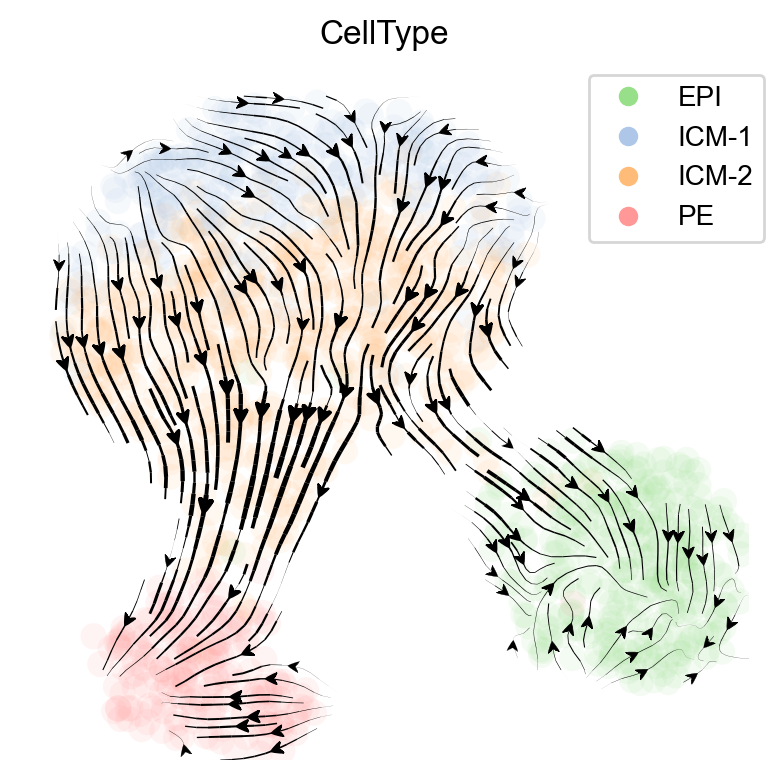

In [132]:
cmap = matplotlib.colormaps["tab20"]
palette = {
    "ICM-1": cmap(1), 
    "ICM-2": cmap(3),
    "EPI": cmap(5),
    "PE": cmap(7),
    "TE-1": cmap(9),
    "TE-2": cmap(11),
    "muralTE": cmap(13),
    "polarTE": cmap(15)
}

color = "CellType"
pointsize = 0.2
dyn.pl.streamline_plot(adata, color=color, color_key=palette, pointsize=pointsize, basis='umap', show_legend=True, figsize=(4, 4))

|-----------> plotting with basis key=X_umap
|-----------> skip filtering leiden by stack threshold when stacking color because it is not a numeric type
|-----------> skip filtering louvain by stack threshold when stacking color because it is not a numeric type


/lustre/grp/tfclab/chenzg/miniconda3/envs/py3/lib/python3.10/site-packages/dynamo/plot/scVectorField.py:1620: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


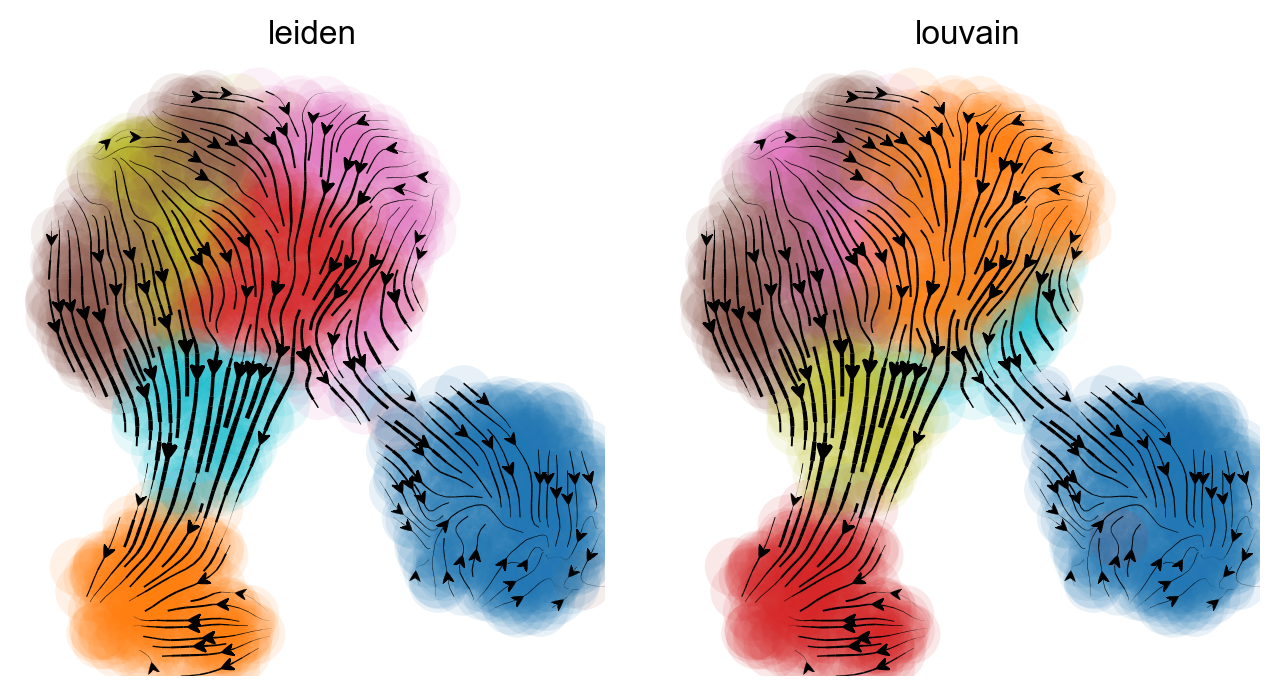

In [133]:
dyn.pl.streamline_plot(adata, color=["leiden", "louvain"], color_key_cmap="tab10", basis='umap', show_legend=False, figsize=(4, 4))

In [134]:
dyn.vf.topography(adata, basis='umap')

/lustre/grp/tfclab/chenzg/miniconda3/envs/py3/lib/python3.10/site-packages/dynamo/vectorfield/topography.py:50: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  x1 = fsolve(F, x01)
/lustre/grp/tfclab/chenzg/miniconda3/envs/py3/lib/python3.10/site-packages/dynamo/vectorfield/topography.py:50: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  x1 = fsolve(F, x01)


AnnData object with n_obs × n_vars = 1260 × 1038
    obs: 'Run', 'Barcode', 'Species', 's4U', 'Time', 'ActD', 'Group', 'CellLine', 'Stage', 'Platform', 'Label', 'UMI', 'Cells', 'LibStruct', 'Remark', 'Cell.Reads', 'Trimmed.Reads', 'Trimmed.Ratio', 'Mapped.Reads', 'Mapped.Ratio', 'Mito.Ratio', 'Filtered.Reads', 'Filtered.Ratio', 'FilteredClip.Reads', 'FilteredClip.Ratio', 'UMIs', 'UMIs.2Reads', 'Duplicate.Reads', 'Duplicate.Ratio', 'Unique.Reads', 'Genes', 'Isoforms.Assembled', 'Isoforms.Known', 'AC.Ratio', 'AG.Ratio', 'AT.Ratio', 'CA.Ratio', 'CG.Ratio', 'CT.Ratio', 'GA.Ratio', 'GC.Ratio', 'GT.Ratio', 'TA.Ratio', 'TC.Ratio', 'TG.Ratio', 'Pe', 'Pc', 'PcPe.Ratio', 'UMIs.2Reads.Nascent.2TCs', 'UMIs.2Reads.Nascent.2TCs.Ratio', 'Genes.2Reads', 'Genes.2Reads.Nascent.2TCs', 'CellType', 'group', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'ntr', 'cell_cy

In [136]:
dyn.pd.fate(adata, adata.obs.index)

KeyError: 'VecFld'